In [40]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import random as ra

from skimage.morphology import skeletonize
import networkx as nx
from scipy.ndimage import distance_transform_edt

import os
import re

In [86]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10

epochs = 10
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [42]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [43]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x0 = self.relu(self.fc0(x))
        x1 = self.relu(self.fc1(x0))
        out = self.fc2(x1) #no ReLU because final decision would be altered, couldn't be "fixed" by other weights anymore, has to stay true!
        return out, [x0, x1, out]

In [44]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

file_pth = 'binary_ffn_all.pth' #this is not a predictor, keys will match
net.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [45]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.62 %


In [46]:
def extract_concepts(img):
    img_np = img.cpu().numpy()
    filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

    skeleton = skeletonize(filtered)
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 4
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 2).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

Text(0.5, 1.0, 'Label: 8')

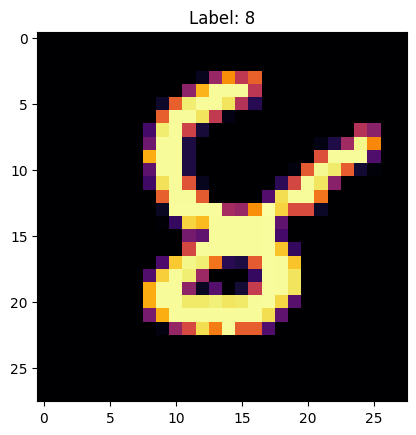

In [47]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 8: #ra.randint(0, 9):
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")
plt.title(f"Label: {labels[ind].item()}")

In [48]:
digit_ints = [i for i in range(10)]
used_indices = []

In [49]:
for _ in range(0):
    for dig in digit_ints:
        while True:
            ind = ra.randrange(0, len(inputs))
            if labels[ind] == dig and ind not in used_indices:
                #used_indices.append(ind)
                img = inputs[ind].squeeze()
                break

        #tensor_groups, original_clusters = extract_concepts(img)
        #torch.save({'tensor_groups': tensor_groups,'original_clusters': original_clusters}, f"somefolder/concepts_dig_{dig}_ind{ind}.pt")


In [50]:
"""indn = 0"""

'indn = 0'

In [51]:
"""plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('extracted sub-concept')
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(tensor_groups[indn].cpu().numpy(), cmap='inferno', alpha=0.6)

img2 = torch.where(
    img != 0,
    torch.tensor(img, device=img.device),
    0.0
)

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(original_clusters[indn], cmap='gray')

plt.axis('off')
plt.show()

indn += 1"""

#################

pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]

In [ ]:
#also possible: only find very small concepts (size = 3, maxoverlap = 0 or 1) 
#and then recombine those to larger ones, would be faster than dfs and work on gpu
#did it on cpu anyway, took 12mins

ind2 = 0

inputs, labels = next(iter(test_loader)) #in test_loader always same order if shuffle=False in batch
while True:
    rand_ind = ra.choice(used_indices)
    label, img = labels[rand_ind], inputs[rand_ind]
    if label == 4:
        break

label.item()

4

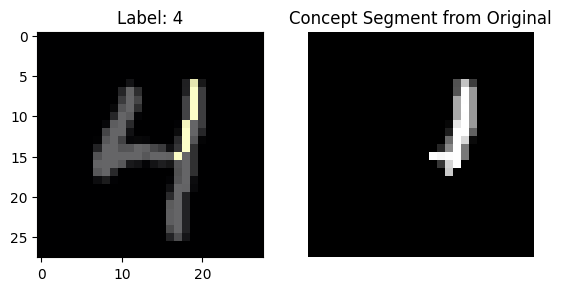

In [53]:
#creating lists of all tensors of all concepts stored:

pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]

tensor_groups_list = []
original_clusters_list = []

for idx in used_indices:
    data = torch.load(f"stored_concepts/concepts_dig_{labels[idx]}_ind{idx}.pt")
    tensor_groups = data['tensor_groups']
    original_clusters = data['original_clusters']

    tensor_groups_list.append(tensor_groups)
    original_clusters_list.append(original_clusters)
    
skeleton_tensors, original_clusters = tensor_groups_list[used_indices.index(rand_ind)], original_clusters_list[used_indices.index(rand_ind)]

plt.subplot(1, 2, 1)
plt.imshow(img.view(28, 28), cmap="gray") #or squeeze()
plt.imshow(skeleton_tensors[ind2].cpu().numpy(), cmap='inferno', alpha=0.6)
plt.title(f"Label: {label}")

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(original_clusters[ind2], cmap='gray')

plt.axis('off')
plt.show()

ind2 = ind2 + 1 if ind2 < len(skeleton_tensors) - 1 else 0

In [54]:
len(skeleton_tensors)

12

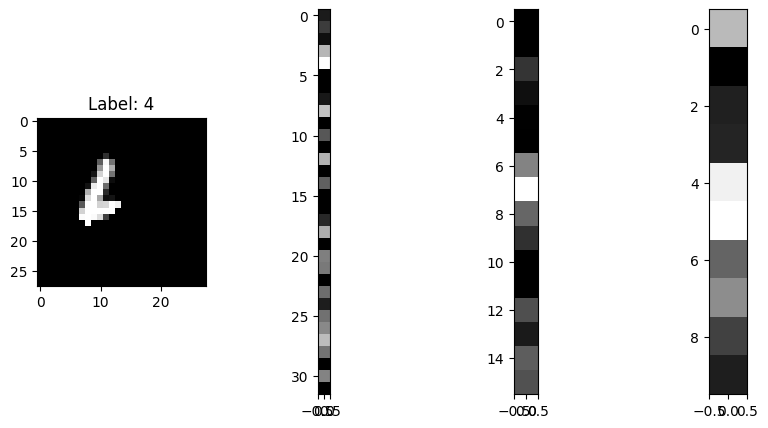

In [ ]:
#forward pass returns out, [x0, x1, out]

def input_to_activation(inp):
    inp = inp.view(-1)
    net.eval()
    with torch.no_grad():
        _, activation_list = net(inp)

        return activation_list


#example to test:
act_list = input_to_activation(original_clusters_list[used_indices.index(rand_ind)][ind2].cuda())  #ra.randint(0, len(original_clusters_list)-1)][ra.randint(0, len(original_clusters)-1)])

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(original_clusters_list[used_indices.index(rand_ind)][ind2], cmap="gray")
plt.title(f"Label: {labels[rand_ind]}")

for i, vector in enumerate(act_list):
    s = vector.shape[0]
    plt.subplot(1, 4, i+2)
    plt.imshow(vector.view(s, 1).cpu().detach().numpy(), cmap="gray")

ind2 = ind2 + 1 if ind2 < len(skeleton_tensors) - 1 else 0

In [56]:
ind2 -= 2
#example: possible observation, only through clicking through it:
#n5 in second hidden layer may activate only on curves not open to the right or down, or lines, not that precisely though

In [57]:
#storing activations:

all_activations = []

for idx in used_indices:
    for idx2 in range(len(original_clusters_list[used_indices.index(idx)])):
        act_list = input_to_activation(original_clusters_list[used_indices.index(idx)][idx2].cuda())
        all_activations.append([act_list, (idx, idx2)])

In [58]:

def find_most_similar(all_activations, target, threshold):
    target_0, target_1, target_2 = target
    
    best_matches = []

    for i, triple in enumerate(all_activations):
        a0, a1, a2 = triple[0]

        d0 = torch.norm(a0 - target_0) #norm means euclidean dist
        d1 = torch.norm(a1 - target_1)
        d2 = torch.norm(a2 - target_2)
        total_distance = d0 + d1 + d2 #d0*0 + d1*0 + d2 is actually not too bad, has variation in hidden layer, but consistent in output, meaning different recombinations, same out

        if total_distance > threshold:
            continue
        else:
            best_matches.append([triple, total_distance, i])

    return best_matches


8

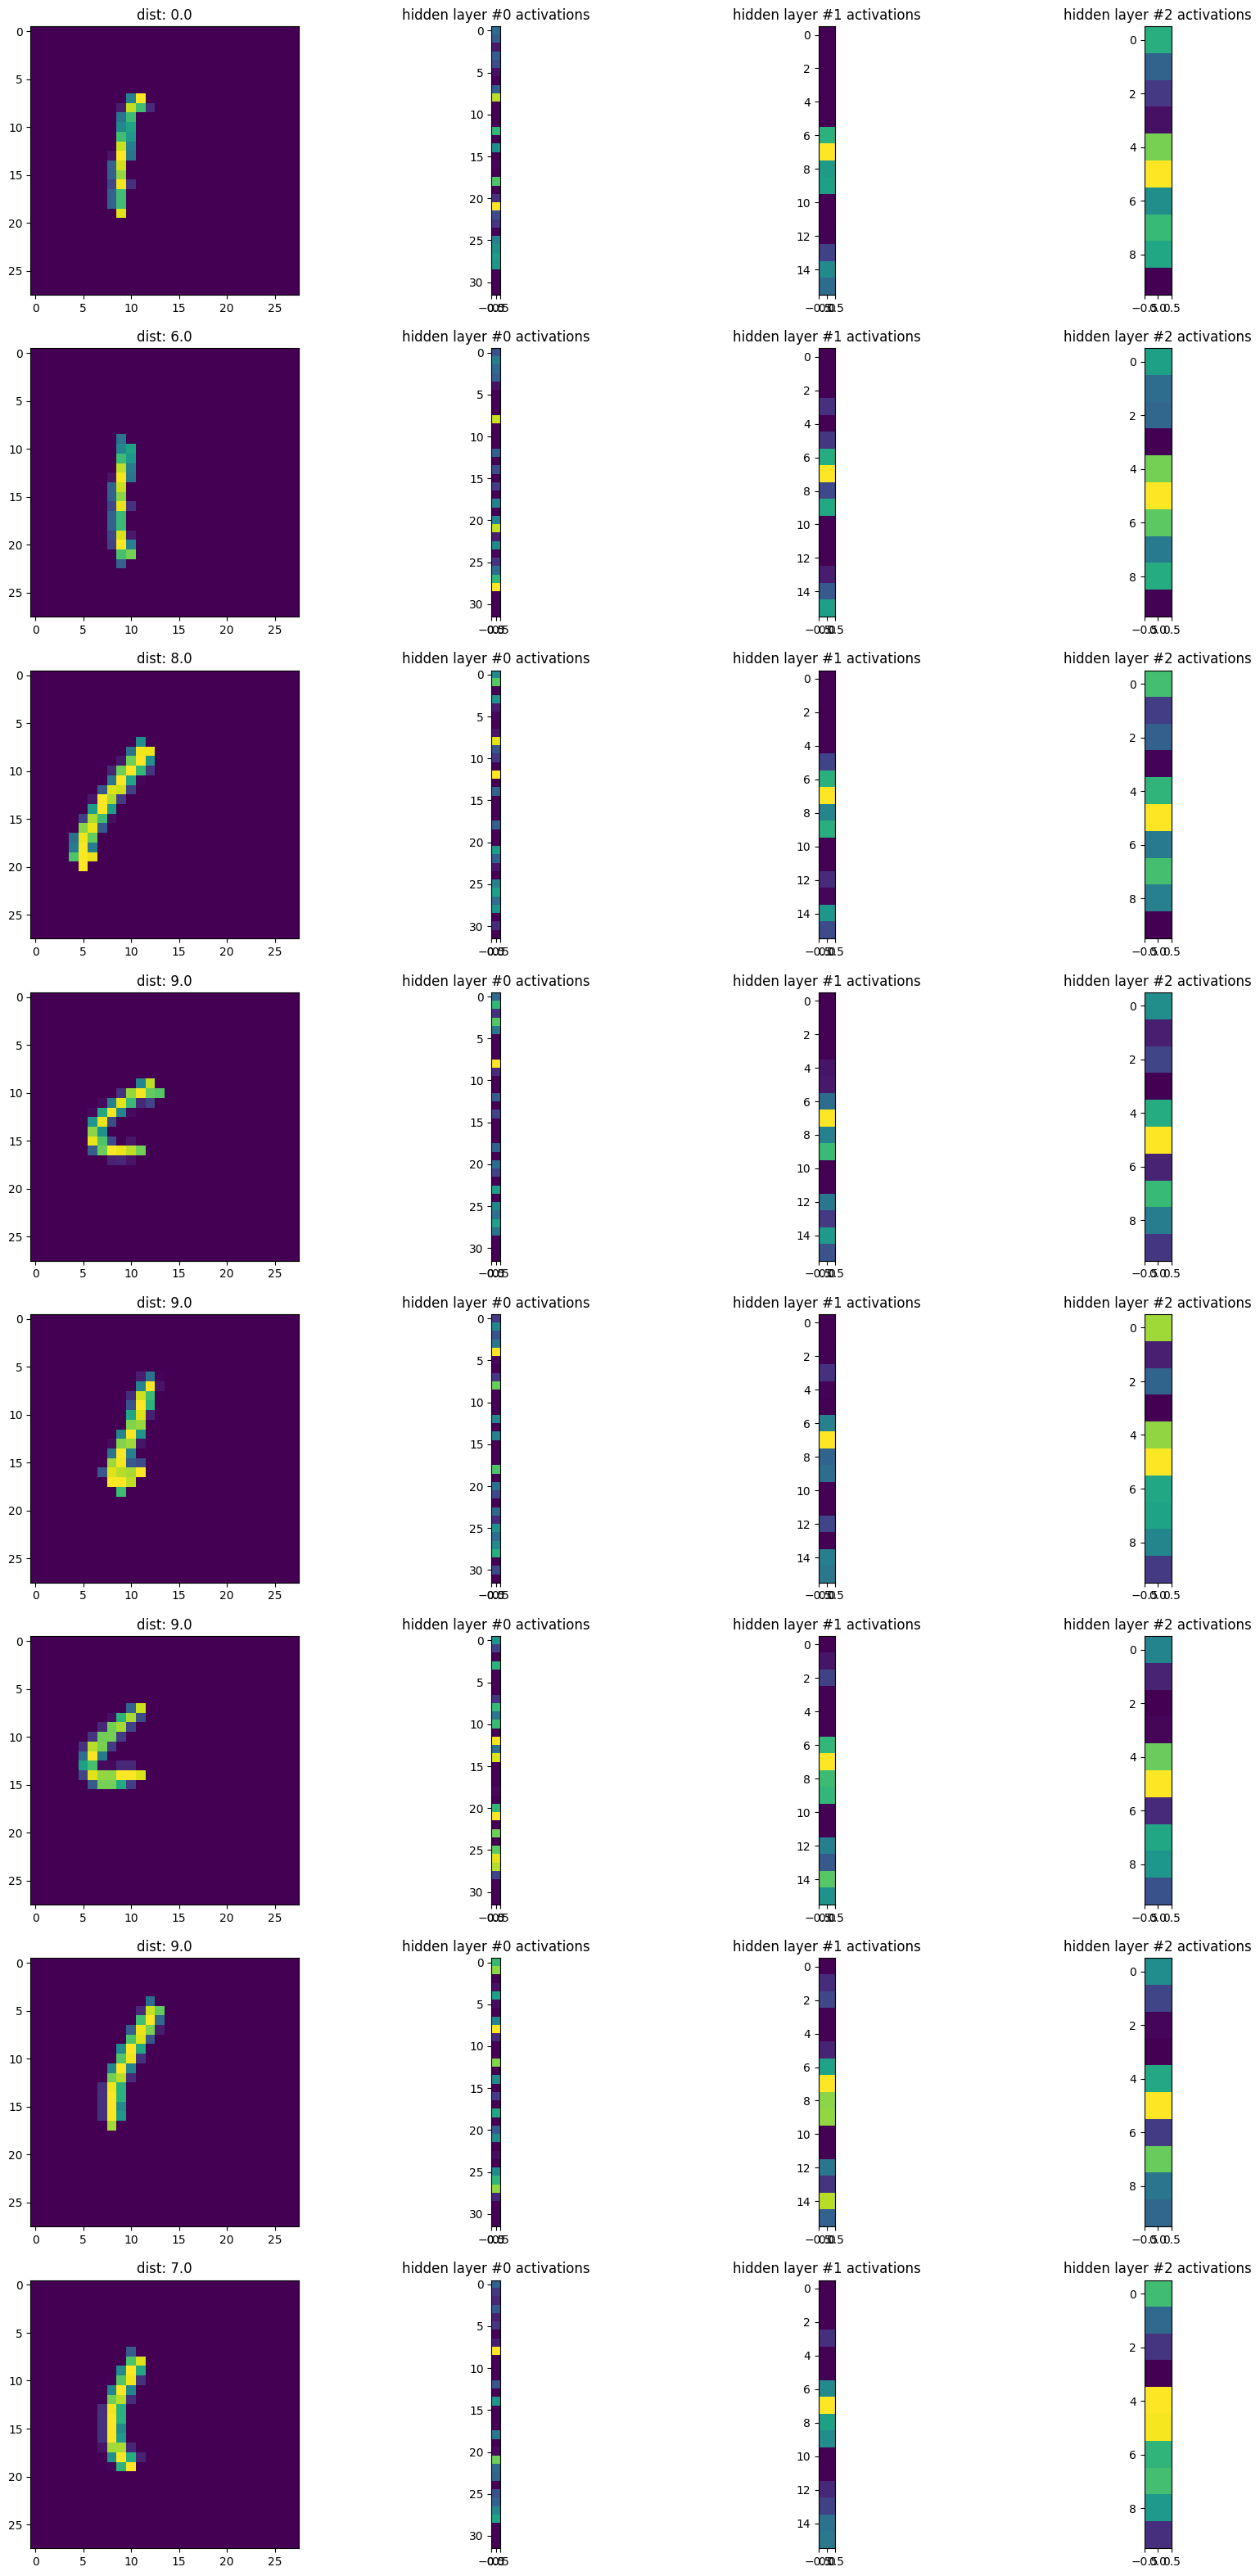

In [59]:

tar = all_activations[ra.randint(0, len(all_activations)-1)][0]
matches = find_most_similar(all_activations, tar, 10)
plt.figure(figsize=(20, len(matches)*5))

for i, match in enumerate(matches):
    triple = match[0]
    dist = match[1]
    ind = match[2]

    idx, idx2 = all_activations[ind][1]

    cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

    plt.subplot(len(matches), 4, i*4+1)
    plt.imshow(cluster.cpu())
    plt.title(f"dist: {torch.round(dist)}")

    for j, vector in enumerate(triple[0]):
        s = vector.shape[0]
        plt.subplot(len(matches), 4, i*4+1+j+1)
        plt.imshow(vector.view(s, 1).cpu())
        plt.title(f"hidden layer #{j} activations")

len(matches)

#seems to be location boudn! perhaps the activations adhere to location because input neurons are based on location and only looking at similar activation means being dependant on that
#finding other relations where activations don't have to just be similar but have a specific new, learnt, relation could allow more precise recognition of low-level concepts, in any location
#angle is also a factor that is not currently generalised to, which is important as it would change the meaning of a feature (information it carries relevant to prediction)


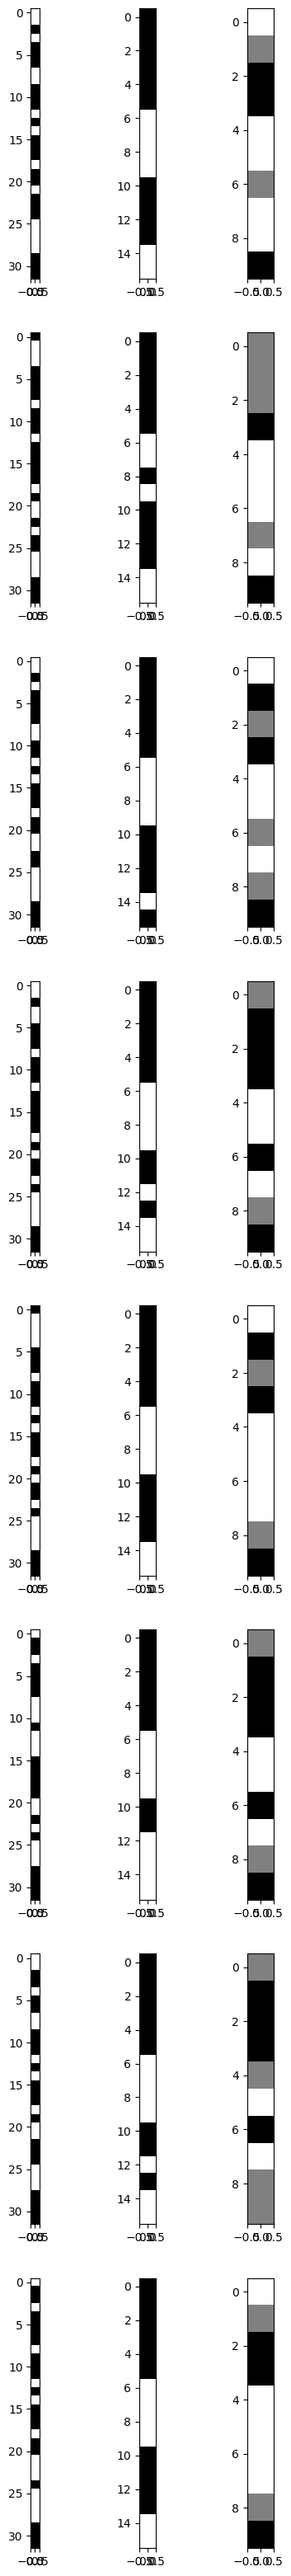

In [60]:
all_masks = []

for i, match in enumerate(matches):
    triple = match[0]
    masks = []

    for vector in triple[0]:
        limit = (torch.max(torch.abs(vector)) + torch.min(torch.abs(vector))) / 2
        masked_vec = torch.where(
            vector >=  limit / 2,
            torch.tensor(1.0, device=vector.device),
            torch.where(
                vector <= -limit / 2,
                torch.tensor(-1.0, device=vector.device),
                torch.tensor(0.0, device=vector.device) #just wrote this chained .where for nothing, I forgot I used ReLU -> no w<0 in hidden l
            )
        )

        masks.append(masked_vec)

    all_masks.append(masks)

plt.figure(figsize=(5, len(all_masks)*5))

for i, masks in enumerate(all_masks):
    for j, mask in enumerate(masks):
        plt.subplot(len(all_masks), 3, 3*i+j+1)
        s = mask.shape[0]
        plt.imshow(mask.view(s, 1).cpu(), cmap="gray")




[3, 5, 6, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 24, 25, 26, 27, 29, 30, 31]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
[]


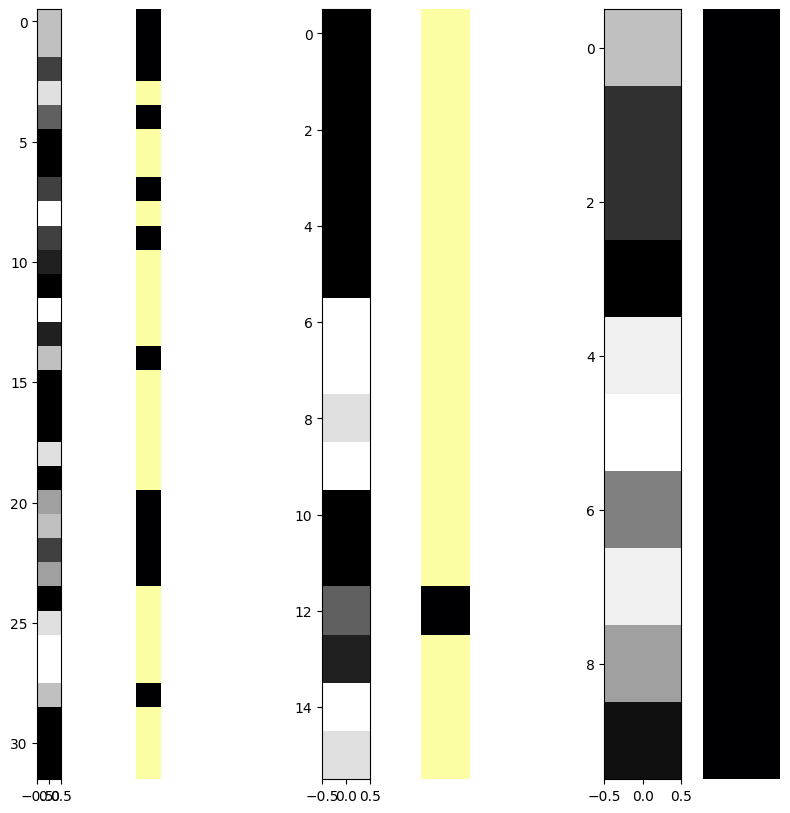

In [61]:

matching_mask_0 = torch.zeros((32))
matching_mask_1 = torch.zeros((16))
matching_mask_2 = torch.zeros((10))

matching_masks = [matching_mask_0, matching_mask_1, matching_mask_2]
out_negative_tensor = torch.zeros((10))

for masks in all_masks:
    for l, layer in enumerate(masks):
        for n in range(layer.shape[0]): #sorry about the ugly nesting...
            val = layer[n]
            matching_masks[l][n] = matching_masks[l][n] + val 
            
            if l == 2 and val < 0:
                out_negative_tensor[n] = out_negative_tensor[n] - 1

#normalising and adding indices part of relevant subnet:
act_l0 = torch.zeros((32))
act_l1 = torch.zeros((16))
act_l2 = torch.zeros((10))
act_list = [act_l0, act_l1, act_l2]

activation_indices = [[], [], []]

for l in range(3):
    if l == 2:
        continue
    
    for n, val in enumerate(matching_masks[l]):
        state = val / len(matches)
        matching_masks[l][n] = state

        binary = (state > 0.75 or state < 0.25)

        if binary:
            activation_indices[l].append(n)
        
        act_list[l][n] = binary


plt.figure(figsize=(10, 10))

plt.subplot(1, 8, 1)
plt.imshow(matching_mask_0.view(32, 1), cmap="gray")

plt.subplot(1, 8, 4)
plt.imshow(matching_mask_1.view(16, 1), cmap="gray")

plt.subplot(1, 8, 7)
plt.imshow(matching_mask_2.view(10, 1), cmap="gray")



plt.subplot(1, 8, 2)
plt.axis(False)
plt.imshow(act_l0.view(32, 1), cmap="inferno")

plt.subplot(1, 8, 5)
plt.axis(False)
plt.imshow(act_l1.view(16, 1), cmap="inferno")

plt.subplot(1, 8, 8)
plt.axis(False)
plt.imshow(act_l2.view(10, 1), cmap="inferno")

print(activation_indices[0])
print(activation_indices[1])
print(activation_indices[2])



In [96]:
import pygame

def draw_mnist_input(scale=20):
    pygame.init()
    size = 28
    window = pygame.display.set_mode((size*scale, size*scale))
    pygame.display.set_caption("Draw a digit (Press Enter to finish)")
    canvas = np.zeros((size, size), dtype=np.float32)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    running = False
                    break
            elif pygame.mouse.get_pressed()[0]:
                x, y = pygame.mouse.get_pos()
                grid_x, grid_y = x // scale, y // scale
                if 0 <= grid_x < size and 0 <= grid_y < size:
                    canvas[grid_y, grid_x] = 1.0
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = grid_x + dx, grid_y + dy
                            if 0 <= nx < size and 0 <= ny < size:
                                canvas[ny, nx] = max(canvas[ny, nx], 0.5)

        for y in range(size):
            for x in range(size):
                val = int(canvas[y, x] * 255)
                pygame.draw.rect(window, (val, val, val), (x*scale, y*scale, scale, scale))

        pygame.display.flip()

    pygame.quit()
    return torch.tensor(canvas).unsqueeze(0)


custom_tensor = draw_mnist_input()
custom_tensor = custom_tensor / custom_tensor.max()
custom_tensor = custom_tensor.view(1, 1, 28, 28)
custom_tensor = F.avg_pool2d(custom_tensor, kernel_size=3, stride=1, padding=1)
pred = net(custom_tensor.view(1, -1).cuda())


custom_acivations = input_to_activation(custom_tensor.cuda())



In [97]:
import pygame
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def draw_on_mnist(mnist_img, scale=20, threshold=2):
    pygame.init()
    size = 28
    screen = pygame.display.set_mode((size*scale, size*scale))
    pygame.display.set_caption("Draw to select parts (Enter = finish)")

    canvas = np.zeros((size, size), dtype=np.float32)
    img_np = mnist_img.squeeze().cpu().numpy()

    scaled_mnist = (img_np * 255).astype(np.uint8)
    scaled_mnist = np.repeat(np.repeat(scaled_mnist, scale, axis=0), scale, axis=1)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                #pygame.quit(); return None
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    pass
            elif pygame.mouse.get_pressed()[0]:
                x, y = pygame.mouse.get_pos()
                gx, gy = x // scale, y // scale
                if 0 <= gx < size and 0 <= gy < size:
                    canvas[gy, gx] = 1.0
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = gx + dx, gy + dy
                            if 0 <= nx < size and 0 <= ny < size:
                                canvas[ny, nx] = 1.0

        for y in range(size):
            for x in range(size):
                val = int(img_np[y, x] * 255)
                if canvas[y, x] > 0:
                    color = (0, 255, 0)
                else:
                    color = (val, val, val)
                pygame.draw.rect(screen, color, (x*scale, y*scale, scale, scale))

        pygame.display.flip()

    pygame.quit()

    inv_draw = 1.0 - canvas
    dist = distance_transform_edt(inv_draw)
    mask = dist <= threshold

    segmented = img_np * mask

    plt.subplot(1,2,1)
    plt.imshow(img_np, cmap='gray'); plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(segmented, cmap='gray'); plt.title("Segmented")
    plt.show()

    return torch.tensor(segmented, dtype=torch.float32).unsqueeze(0)


10 25
Matching the few learnt concepts: 71.0%
(tensor([-9.5381,  0.1420, -9.7526, -1.6672, -7.8193,  8.4248, -2.3138, -2.3601,
        -5.7276, -3.3720], device='cuda:0', grad_fn=<ViewBackward0>), [tensor([2.1516, 4.6853, 4.1060, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9751,
        0.3663, 0.3584, 1.4257, 2.4763, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.5628, 4.0130, 0.0381, 0.0311, 1.1836, 0.0000, 4.1843, 2.9164,
        4.5627, 0.0000, 0.0000, 0.0000, 1.0530], device='cuda:0',
       grad_fn=<ReluBackward0>), tensor([0.6082, 5.8886, 5.6735, 0.0000, 0.7231, 3.7690, 4.2535, 3.1672, 0.0000,
        7.7074, 0.0000, 0.0000, 0.2683, 0.0000, 6.0709, 0.6826],
       device='cuda:0', grad_fn=<ReluBackward0>), tensor([-9.5381,  0.1420, -9.7526, -1.6672, -7.8193,  8.4248, -2.3138, -2.3601,
        -5.7276, -3.3720], device='cuda:0', grad_fn=<ViewBackward0>)])


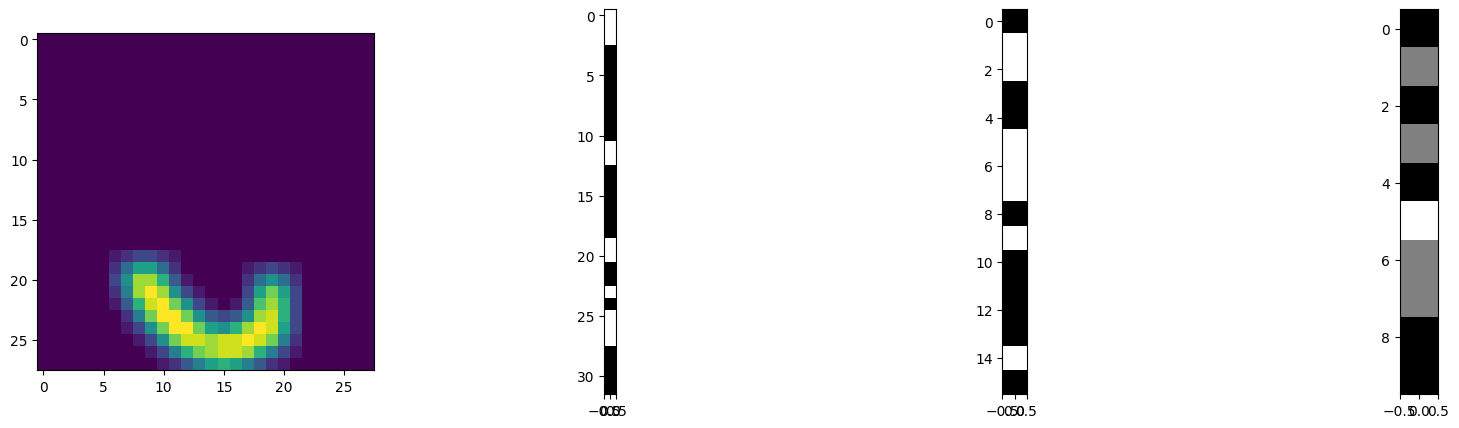

In [98]:
randin = ra.randint(0, len(all_activations)-1)
element = all_activations[randin]

acts = element[0]
idx, idx2 = element[1]

"""acts = matches[18][0][0]
ind = matches[18][2]

idx, idx2 = all_activations[ind][1]"""

cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
#plt.imshow(original_clusters_list[used_indices.index(idx)][idx2])
plt.imshow(custom_tensor.squeeze())

masks = []

for vector in custom_acivations: #acts:
    limit = (torch.max(torch.abs(vector)) + torch.min(torch.abs(vector))) / 2
    masked_vec = torch.where(
        vector >=  limit / 2,
        torch.tensor(1.0, device=vector.device),
        torch.where(
            vector <= -limit / 2,
            torch.tensor(-1.0, device=vector.device),
            torch.tensor(0.0, device=vector.device)
        )
    )

    masks.append(masked_vec)

matching_binary_masks = []

for vector in matching_masks:
    limit = (torch.max(torch.abs(vector)) + torch.min(torch.abs(vector))) / 2
    masked_vec = torch.where(
        vector >=  limit / 2,
        torch.tensor(1.0, device=vector.device),
        torch.where(
            vector <= -limit / 2,
            torch.tensor(-1.0, device=vector.device),
            torch.tensor(0.0, device=vector.device) #just wrote this chained .where for nothing, I forgot I used ReLU -> no w<0 in hidden l
        )
    )

    matching_binary_masks.append(masked_vec)

mismatches = 0
notmismatches = 0

for i, indices in enumerate(activation_indices):
    layer = masks[i]

    plt.subplot(1, 4, i+2)
    plt.imshow(layer.view(layer.shape[0], 1).cpu(), cmap="gray")

    for idx in indices:
        if layer[idx] != matching_binary_masks[i][idx]:
            mismatches += 1
        else:
            notmismatches += 1


print(mismatches, notmismatches)
print(f"Matching the few learnt concepts: {round(notmismatches/(mismatches+notmismatches), 2) * 100}%")


#plt.imshow(cluster.cpu())

out = net(custom_tensor.view(-1).cuda())
print(out)
#print(torch.argmax(out))


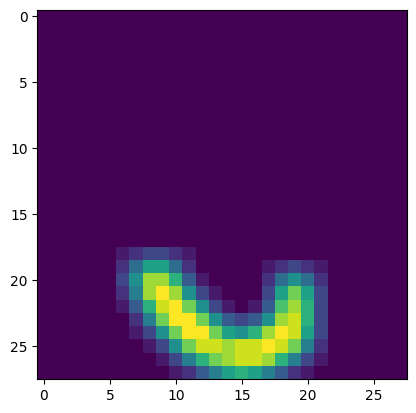

<Figure size 2000x0 with 0 Axes>

In [99]:
activation = input_to_activation(custom_tensor.view(28, 28).cuda())
matches = find_most_similar(all_activations, activation, 10)
matches = sorted(matches, key=lambda x: x[1])

plt.imshow(custom_tensor.view(28, 28))

plt.figure(figsize=(20, len(matches)*5))
for i, match in enumerate(matches):
    triple = match[0]
    dist = match[1]
    ind = match[2]

    idx, idx2 = all_activations[ind][1]

    cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

    plt.subplot(len(matches), 4, i*4+1)
    plt.imshow(cluster.cpu())
    plt.title(f"dist: {torch.round(dist)}")

    for j, vector in enumerate(triple[0]):
        s = vector.shape[0]
        plt.subplot(len(matches), 4, i*4+1+j+1)
        plt.imshow(vector.view(s, 1).cpu())
        plt.title(f"hidden layer #{j} activations")

In [100]:
#next: get entire digit, the prediction, and the sub-nets influence on the decision, then reconstruct the decision making process with concepts only:
#segmentation + concept identification + comparison to learnt patterns for this class

In [66]:
diff_acts = [[0 for _ in range(le)] for le in [32, 16, 10]]

tensor([ -9.7761,  -9.4129,  -6.5732,  -0.3189,  -6.4614,  -5.6605,  -9.5553,
        -11.8114,   7.9291,  -5.7317], device='cuda:0',
       grad_fn=<ViewBackward0>)


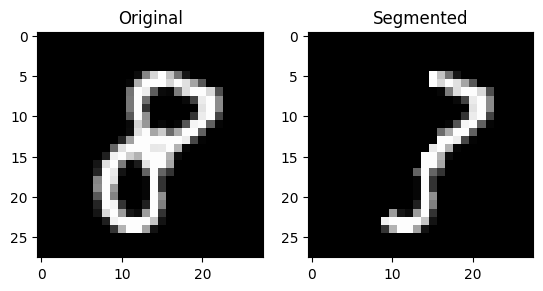

In [67]:
inputs, labels = next(iter(test_loader))
while True:
    idx = ra.randint(0, len(inputs)-1)
    if labels[idx] == 8:
        break

testpred = net(inputs[idx].view(-1).cuda())
print(testpred[0])

seg_tensor = draw_on_mnist(inputs[idx])

In [68]:
pred = net(inputs[idx].view(-1).cuda())
pred2 = net(seg_tensor.view(-1).cuda())

print(pred[0])

for i in range(10):
    print(f"{i}: {round(pred[0][i].item(), 2)} to {round(pred2[0][i].item(), 2)}")

tensor([ -9.7761,  -9.4129,  -6.5732,  -0.3189,  -6.4614,  -5.6605,  -9.5553,
        -11.8114,   7.9291,  -5.7317], device='cuda:0',
       grad_fn=<ViewBackward0>)
0: -9.78 to -5.76
1: -9.41 to -4.79
2: -6.57 to -3.76
3: -0.32 to 0.46
4: -6.46 to -7.42
5: -5.66 to -13.36
6: -9.56 to -12.85
7: -11.81 to -1.96
8: 7.93 to 1.45
9: -5.73 to -1.78


[tensor(1.3902, device='cuda:0'), tensor(6.4393, device='cuda:0'), tensor(0., device='cuda:0'), tensor(3.9991, device='cuda:0'), tensor(0., device='cuda:0')]


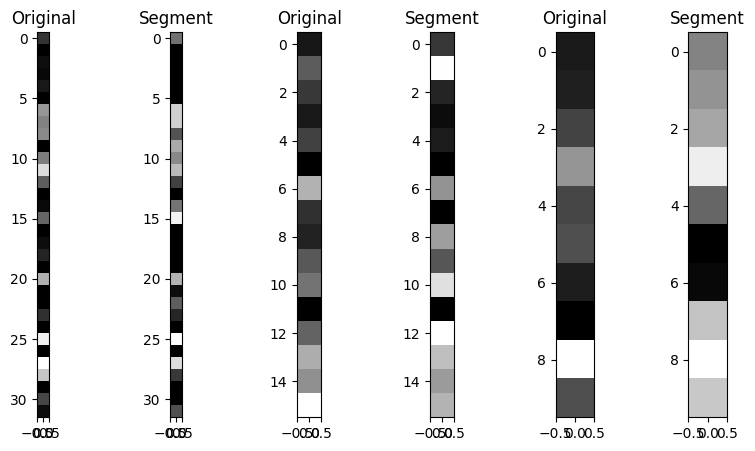

In [69]:
acts_original = input_to_activation(inputs[idx].cuda())
acts_segmented = input_to_activation(seg_tensor.cuda())

plt.figure(figsize=(10, 5))
for i, vec in enumerate(acts_original):
    plt.subplot(1, 6, i*2+1)
    plt.imshow(vec.view(vec.shape[0], 1).cpu(), cmap="gray")
    plt.title("Original")

for i, vec in enumerate(acts_segmented):
    plt.subplot(1, 6, i*2+2)
    plt.imshow(vec.view(vec.shape[0], 1).cpu(), cmap="gray")
    plt.title("Segment")


#3, 4, 6, 9, 21, 27
#0, 1, 5, 8, 9, 11, 12, 15
#3, 6, 7, 8

print([acts_segmented[1][idx] for idx in [0, 1, 5, 8, 11]])

In [81]:
l16 = []
l16.append(acts_segmented[1])

In [82]:
value_tuples = []

for n in range(16):
    if n not in [0, 1, 5, 8, 11]:
        continue
    avg = 0
    for sample in l16:
        avg += sample[n]

    avg /= len(l16)
    value_tuples.append((avg, n))

In [83]:
score = 0

for el in value_tuples:
    val, ind = el
    val_vec = acts_segmented[1][ind]
    if abs(val-val_vec) < 1:
        score += 1

print(f"score / 5: {score}")

score / 5: 5


In [84]:
print(value_tuples)

[(tensor(1.3902, device='cuda:0'), 0), (tensor(6.4393, device='cuda:0'), 1), (tensor(0., device='cuda:0'), 5), (tensor(3.9991, device='cuda:0'), 8), (tensor(0., device='cuda:0'), 11)]


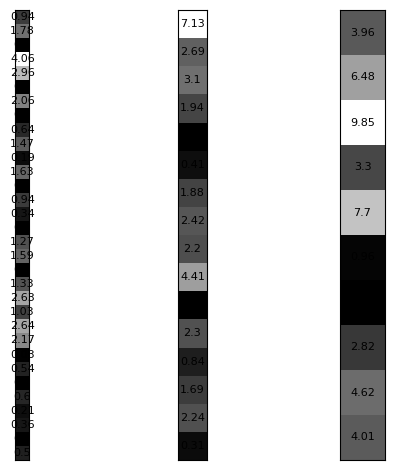

In [75]:
diff0, diff1, diff2 = torch.zeros((32)), torch.zeros((16)), torch.zeros((10)), 
differences = [diff0, diff1, diff2]

for ind, vec in enumerate(acts_original):
    for n in range(len(vec)):
        differences[ind][n] = abs(vec[n] - acts_segmented[ind][n])

"""for i, diff in enumerate(differences):
    plt.subplot(1, 3, i+1)
    plt.imshow(diff.view(diff.shape[0], 1), cmap="gray")
"""

for i, diff in enumerate(differences):
    ax = plt.subplot(1, 3, i+1)
    im = ax.imshow(diff.detach().cpu().numpy().reshape(-1, 1), cmap="gray", origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    for j in range(diff.shape[0]):
        if diff[j].item() >= 3:
            diff_acts[i][j] += 1
        ax.text(0, j, str(round(diff[j].item(), 2)), ha='center', va='center',
                color='black' if diff[j].item() < (im.norm.vmin + im.norm.vmax) / 2 else 'black',
                fontsize=8)

plt.tight_layout()
plt.show()


#note:
#0, 4, 29
#0--, 5
#3, 8

In [76]:
diff_acts

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 0, 1, 1, 1, 1, 1]]

In [77]:
#results for thresh. >= 1.5:
imp_diffs_15 = [[12,
  6,
  1,
  7,
  7,
  0,
  5,
  0,
  1,
  4,
  3,
  1,
  0,
  4,
  1,
  0,
  1,
  4,
  1,
  0,
  0,
  5,
  1,
  3,
  3,
  0,
  1,
  9,
  0,
  2,
  2,
  5],
 [13, 11, 6, 6, 6, 12, 1, 0, 8, 10, 9, 11, 5, 0, 9, 6],
 [8, 9, 11, 14, 11, 12, 13, 15, 15, 10]]

#3, 4, 6, 9, 21, 27
#0, 1, 8, 9, 11, 12, 15
#3, 6, 7, 8

#for thresh. >= 2.5:
imp_diffs_25 = [[4,
  2,
  0,
  2,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  2,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0],
 [7, 9, 0, 0, 5, 10, 0, 0, 7, 4, 4, 7, 1, 0, 3, 0],
 [5, 10, 3, 10, 7, 5, 10, 10, 10, 7]]

#for thresh. >= 3:
imp_diffs_30 = [[2,
  2,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  1,
  0,
  0,
  2,
  0,
  0,
  0,
  0],
 [6, 6, 0, 1, 7, 4, 0, 0, 1, 1, 4, 4, 0, 0, 2, 0],
 [3, 3, 5, 8, 8, 3, 9, 10, 8, 5]]

#for thresh. >= 3.5:
imp_diffs_35 = [[1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [4, 4, 0, 0, 2, 5, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [2, 6, 4, 7, 5, 4, 8, 8, 9, 2]]



In [78]:
concept_ind0, concept_ind1, concept_ind2,  = torch.zeros((32)), torch.zeros((16)), torch.zeros((10)), 
concept_inds = [concept_ind0, concept_ind1, concept_ind2]

for i, vec in enumerate(imp_diffs_25):
    for n in range(len(vec)):
        pass